# Example 4: classify CIFAR-10 images using CNN followed by fully-connected layer with dropout using one-hot encoding of classes and softmax activation

### with help from:
* https://www.coursera.org/specializations/deep-learning homework
* https://liufuyang.github.io/2017/03/17/just-another-tensorflow-beginner-guide-2.html examples

In [1]:
import numpy as np
import tensorflow as tf
import math

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from datetime import datetime
import time

In [3]:
# progress bar and loop timing
from tqdm import tnrange, tqdm_notebook

In [4]:
# reset everything
tf.reset_default_graph()
np.random.seed(1)
seed = 3

In [5]:
# configuration
batch_size = 64
learning_rate = 0.001
training_epochs = 10

# keep probability for dropout
keep = 0.5

### functions

In [6]:
def random_mini_batches_img(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    
    from Andrew Ng - Coursera Deep Learning Specialization,
        https://www.coursera.org/specializations/deep-learning
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [7]:
def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    
    from Andrew Ng - Coursera Deep Learning Specialization,
        https://www.coursera.org/specializations/deep-learning
    """
    
    # Create a tf.constant equal to C (depth), name it 'C'.
    C = tf.constant(C, name = "C")
    
    # Use tf.one_hot, be careful with the axis
    one_hot_matrix = tf.one_hot(labels, C, axis=0)
    
    # Create and run the session
    with tf.Session() as sess:
        one_hot = sess.run(one_hot_matrix)
    
    return one_hot

## The CIFAR-10 dataset

* Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.
    * https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf

### load data and see what is in it: see https://www.cs.toronto.edu/~kriz/cifar.html

In [8]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [9]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [10]:
CifarPath = 'data/cifar-10-batches-py/'
all_data = [0,1,2,3,4,5,6]
for i, direct in zip(all_data,dirs):
    all_data[i] = unpickle(CifarPath+direct)

In [11]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [12]:
batch_meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [13]:
data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [14]:
X = data_batch1[b'data']
y = data_batch1[b'labels']
print(np.shape(X))
print(np.shape(y))

(10000, 3072)
(10000,)


In [15]:
print(type(X))
print(type(y))

<class 'numpy.ndarray'>
<class 'list'>


In [16]:
X = np.reshape(X,(10000,3,32,32))
X = X.transpose(0,2,3,1)
X = X.astype("uint8")

y = np.reshape(y,(10000,1))
y = y.astype("uint8")

print(np.shape(X))
print(np.shape(y))

print(type(X))
print(type(y))

print (X.max(), X.min())

(10000, 32, 32, 3)
(10000, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
255 0


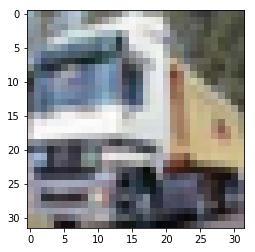

In [17]:
plt.imshow(X[1])

In [18]:
print(y[1])

[9]


### format data for processing with CNN

In [19]:
# using CIFAR-10
n_classes = 10

# image size 32x32
nh = 32
nw = 32

# color images
nc = 3

# number of examples
num_examples = 50000

In [20]:
# combine all training data set batches
training_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]

In [21]:
X_train = np.vstack([d[b'data'] for d in training_batches])
y_train = np.hstack([d[b'labels'] for d in training_batches])

print (np.shape(X_train))
print (np.shape(y_train))

X_train = np.reshape(X_train,(len(X_train),3,32,32))
X_train = X_train.transpose(0,2,3,1)
X_train = X_train.astype("uint8")
X_train = X_train/255.0

# y_train = np.reshape(y_train,(len(y_train),1))
y_train = one_hot_matrix(y_train,n_classes).T
y_train = y_train.astype("uint8")

print (np.shape(X_train))
print(np.shape(y_train))

(50000, 3072)
(50000,)
(50000, 32, 32, 3)
(50000, 10)


In [22]:
X_test = test_batch[b'data']
y_test = test_batch[b'labels']

print(np.shape(X_test))
print(np.shape(y_test))

X_test = np.reshape(X_test,(len(X_test),3,32,32))
X_test = X_test.transpose(0,2,3,1)
X_test = X_test.astype("uint8")
X_test = X_test/255.0

# y_test = np.reshape(y_test,(len(y_test),1))
y_test = one_hot_matrix(y_test,n_classes).T
y_test = y_test.astype("uint8")

print(np.shape(X_test))
print(np.shape(y_test))

(10000, 3072)
(10000,)
(10000, 32, 32, 3)
(10000, 10)


### data input and formatted properly!

## CNN

In [23]:
# tensorboard log file path
logs_path = './tmp/example4/'+datetime.now().isoformat()

In [24]:
# reset everything
tf.reset_default_graph()
np.random.seed(1)
seed = 3

### tensorflow constants, variables, placeholders

In [25]:
with tf.name_scope('input'):
    X = tf.placeholder(tf.float32, shape=[None, nh, nw, nc], name="X")
    y_true = tf.placeholder(tf.float32, shape=[None, n_classes], name="y_true")
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")

In [26]:
with tf.name_scope('filterWeights'):
    W1 = tf.get_variable("W1", [4, 4, nc, 8], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [2, 2, 8, 32], initializer = tf.contrib.layers.xavier_initializer(seed=0))
# tensorflow's fully-connected function used here initializes its own weights automatically

### define computation graph

In [27]:
with tf.name_scope('convLayer1'):
    z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding='SAME')
    a1 = tf.nn.relu(z1)
    p1 = tf.nn.max_pool(a1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
with tf.name_scope('convLayer2'):
    z2 = tf.nn.conv2d(p1, W2, strides=[1,1,1,1], padding='SAME')
    a2 = tf.nn.relu(z2)
    p2 = tf.nn.max_pool(a2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
with tf.name_scope('fullyConnected'):
    p2 = tf.contrib.layers.flatten(p2)
    p2_drop = tf.nn.dropout(p2,keep_prob=keep)
    y = tf.contrib.layers.fully_connected(p2_drop, n_classes, activation_fn=None)
# with tf.name_scope('softmax'):
#     y  = tf.nn.softmax(z3)

print (str(p1))
print (str(p2))
print (str(y))

Tensor("convLayer1/MaxPool:0", shape=(?, 16, 16, 8), dtype=float32)
Tensor("fullyConnected/Flatten/flatten/Reshape:0", shape=(?, 2048), dtype=float32)
Tensor("fullyConnected/fully_connected/BiasAdd:0", shape=(?, 10), dtype=float32)


### cost function

In [28]:
# with tf.name_scope('cross_entropy'):
#     cost = tf.reduce_mean(-tf.reduce_sum(y_true * tf.log(y)))

# this cross-entropy function does softmax automatically
with tf.name_scope('cross_entropy'):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true, \
                                                                     logits=y))

### optimizer¶

In [29]:
with tf.name_scope('train'):
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train = optimizer.minimize(cost)

### metrics¶

In [30]:
with tf.name_scope('accuracy'):
    correct_predictions = tf.equal(tf.argmax(y,1),tf.argmax(y_true,1))   
    accuracy = tf.reduce_mean(tf.cast(correct_predictions,tf.float32))

### log results

In [31]:
# summary for tensorboard
train_cost_summary = tf.summary.scalar("train_cost", cost)
train_accuracy_summary = tf.summary.scalar("train_accuracy", accuracy)

test_cost_summary = tf.summary.scalar("test_cost", cost)
test_accuracy_summary = tf.summary.scalar("test_accuracy", accuracy)

### main program¶

In [32]:
init = tf.global_variables_initializer()

In [33]:
with tf.Session() as sess:
    sess.run(init)
    
    # tensorboard log file writer    
    writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    
    batch_count = np.int(num_examples/batch_size)
    print ('number of mini_batches: ',batch_count)

    for epoch in tnrange(training_epochs, desc='epoch'):
        
        seed = seed+1
        mini_batches = random_mini_batches_img(X_train, y_train, batch_size, seed=seed)
        
        iter = 0        
        for mini_batch in mini_batches:
            
            iter = iter+1

            (batch_x, batch_y) = mini_batch
            
            _, train_cost, train_accuracy, _train_cost_summary, _train_accuracy_summary = \
               sess.run([train, cost, accuracy, train_cost_summary, train_accuracy_summary], \
                   feed_dict={X: batch_x, y_true: batch_y, keep_prob:keep})
            
            writer.add_summary(_train_cost_summary, epoch * batch_count + iter)
            writer.add_summary(_train_accuracy_summary, epoch * batch_count + iter)
       
            if iter % 100 == 0:
                # for log on test data:
                test_cost, test_accuracy, _test_cost_summary, _test_accuracy_summary = \
                    sess.run([cost, accuracy, test_cost_summary, test_accuracy_summary], \
                        feed_dict={X:X_test, y_true:y_test, keep_prob:1.0})
                # write log
                writer.add_summary(_test_cost_summary, epoch * batch_count + iter)
                writer.add_summary(_test_accuracy_summary, epoch * batch_count + iter)
                
                print('Epoch {0:3d}, Batch {1:3d} | Train Cost: {2:.2f} | Test Cost: {3:.2f} | Train Accuracy: {4:.2f} | Test Accuracy: {5:.2f}'.format(epoch, iter, train_cost, test_cost, train_accuracy, test_accuracy))
            
    print('\nFinal Test Set Accuracy: {}'.format(accuracy.eval(feed_dict={X:X_test, y_true:y_test, keep_prob:1.0})))

number of mini_batches:  781


Epoch   0, Batch 100 | Train Cost: 1.95 | Test Cost: 1.94 | Train Accuracy: 0.28 | Test Accuracy: 0.31
Epoch   0, Batch 200 | Train Cost: 1.78 | Test Cost: 1.77 | Train Accuracy: 0.41 | Test Accuracy: 0.38
Epoch   0, Batch 300 | Train Cost: 1.58 | Test Cost: 1.68 | Train Accuracy: 0.42 | Test Accuracy: 0.41
Epoch   0, Batch 400 | Train Cost: 1.63 | Test Cost: 1.63 | Train Accuracy: 0.44 | Test Accuracy: 0.42
Epoch   0, Batch 500 | Train Cost: 1.46 | Test Cost: 1.58 | Train Accuracy: 0.50 | Test Accuracy: 0.44
Epoch   0, Batch 600 | Train Cost: 1.39 | Test Cost: 1.54 | Train Accuracy: 0.48 | Test Accuracy: 0.46
Epoch   0, Batch 700 | Train Cost: 1.67 | Test Cost: 1.51 | Train Accuracy: 0.39 | Test Accuracy: 0.46
Epoch   1, Batch 100 | Train Cost: 1.33 | Test Cost: 1.49 | Train Accuracy: 0.52 | Test Accuracy: 0.47
Epoch   1, Batch 200 | Train Cost: 1.45 | Test Cost: 1.50 | Train Accuracy: 0.52 | Test Accuracy: 0.47
Epoch   1, Batch 300 | Train Cost: 1.74 | Test Cost: 1.49 | Train Accurac